# Fake news detection using ML 
Sushwanth Reddy
17STUCHH010063

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [92]:
# fake = pd.read_csv("/content/Fake.csv")
# true = pd.read_csv("/content/True.csv")

data = pd.read_csv('/Dataset2/fake_or_real_news.csv')

In [93]:
data.shape

(6335, 4)

In [94]:
# REAL.shape

## Data cleaning and preparation

In [95]:
# Add flag to track fake and real
# fake['target'] = 'fake'
# true['target'] = 'true'

# data['label'] = 'FAKE'
# data['label'] = 'REAL'

In [96]:
# # Concatenate dataframes
# data = pd.concat([fake, true]).reset_index(drop = True)
# data.shape

In [97]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [98]:
# Check the data
data.head()

,Unnamed: 0,title,text,label
0,3319,Combat veterans face ‘cruel’ struggle to prove...,Stanley Friedman was shot at. The ship he was ...,REAL
1,2627,'There appear to be no rules anymore',There is an path for Democrats to regain the p...,REAL
2,7111,Comment on Morning Joe Destroys Corrupt Clinto...,Abby Martin Exposes What Hillary Clinton Reall...,FAKE
3,6778,Future Diwali celebrations to be organized by ...,"Monday, 31 October 2016 Diwali firework celebr...",FAKE
4,4888,Self-proclaimed “genius” reaches new highs in ...,The Clinton campaign reacted with yet another ...,REAL


In [99]:
# Removing the date (we won't use it for the analysis)
# data.drop(["date"],axis=1,inplace=True)
# data.head()

In [100]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,Unnamed: 0,text,label
0,3319,Stanley Friedman was shot at. The ship he was ...,REAL
1,2627,There is an path for Democrats to regain the p...,REAL
2,7111,Abby Martin Exposes What Hillary Clinton Reall...,FAKE
3,6778,"Monday, 31 October 2016 Diwali firework celebr...",FAKE
4,4888,The Clinton campaign reacted with yet another ...,REAL


In [101]:
# Removing the title (we will only use the text)
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,text,label
0,Stanley Friedman was shot at. The ship he was ...,REAL
1,There is an path for Democrats to regain the p...,REAL
2,Abby Martin Exposes What Hillary Clinton Reall...,FAKE
3,"Monday, 31 October 2016 Diwali firework celebr...",FAKE
4,The Clinton campaign reacted with yet another ...,REAL


In [102]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,label
0,stanley friedman was shot at. the ship he was ...,REAL
1,there is an path for democrats to regain the p...,REAL
2,abby martin exposes what hillary clinton reall...,FAKE
3,"monday, 31 october 2016 diwali firework celebr...",FAKE
4,the clinton campaign reacted with yet another ...,REAL


In [103]:
# data = pd.read_csv('/content/fake_or_real_news.csv')

# data.drop(["title"],axis=1,inplace=True)
# data['text'] = data['text'].apply(lambda x: x.lower())
# data.head()

In [104]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [105]:
# Check
data.head()

,text,label
0,stanley friedman was shot at the ship he was o...,REAL
1,there is an path for democrats to regain the p...,REAL
2,abby martin exposes what hillary clinton reall...,FAKE
3,monday 31 october 2016 diwali firework celebra...,FAKE
4,the clinton campaign reacted with yet another ...,REAL


In [106]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
data.head()

,text,label
0,stanley friedman shot ship attacked enemy bomb...,REAL
1,path democrats regain presidency — run ohio mi...,REAL
2,abby martin exposes hillary clinton really rep...,FAKE
3,monday 31 october 2016 diwali firework celebra...,FAKE
4,clinton campaign reacted yet another ad featur...,REAL


## Basic data exploration

In [108]:
# # How many articles per subject?
# print(data.groupby(['subject'])['text'].count())
# data.groupby(['subject'])['text'].count().plot(kind="bar")
# plt.show()

label
FAKE    3164
REAL    3171
Name: text, dtype: int64


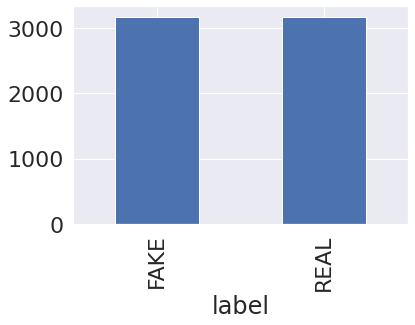

In [109]:
# How many fake and real articles?
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

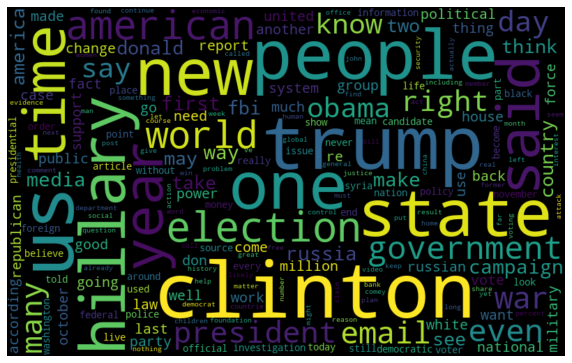

In [110]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["label"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

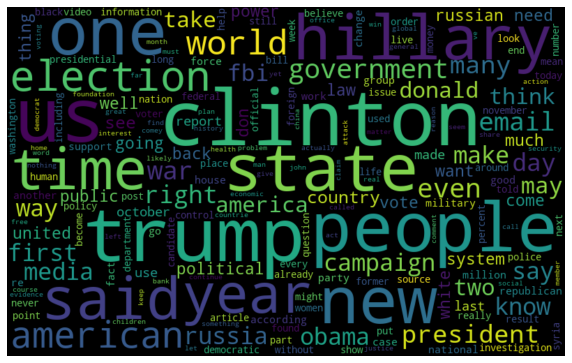

In [111]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["label"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [112]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

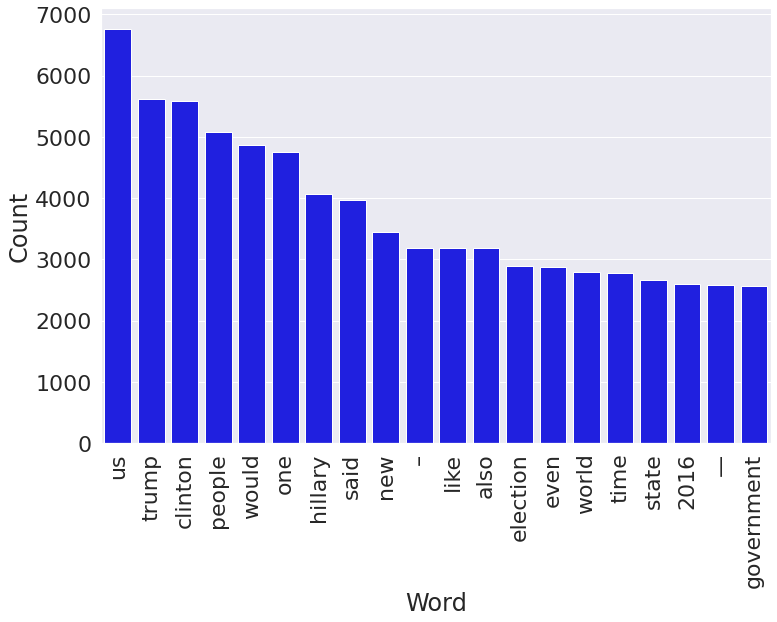

In [113]:
# Most frequent words in fake news
counter(data[data["label"] == "FAKE"], "text", 20)

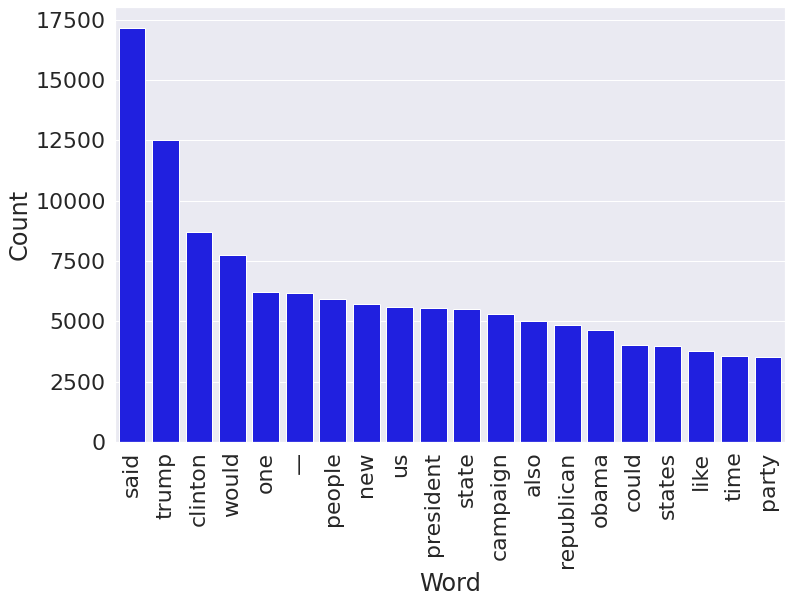

In [114]:
# Most frequent words in real news
counter(data[data["label"] == "REAL"], "text", 20)

## Modeling

In [115]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# **Ensemble**


In [116]:
# df = pd.read_csv('/content/fake_or_real_news.csv')
# df.head()



### Peparing the data

In [117]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=0)

In [118]:
data

,text,label
0,stanley friedman shot ship attacked enemy bomb...,REAL
1,path democrats regain presidency — run ohio mi...,REAL
2,abby martin exposes hillary clinton really rep...,FAKE
3,monday 31 october 2016 diwali firework celebra...,FAKE
4,clinton campaign reacted yet another ad featur...,REAL
...,...,...
6330,protestors activists special interests us news...,FAKE
6331,nasa revealed curious incident 2010 might firm...,FAKE
6332,house majority leader kevin mccarthy considere...,REAL
6333,hillary clintons postapocalyptic hellscape pla...,FAKE


# **Naive Bayes**




In [119]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 85.0%


Confusion matrix, without normalization


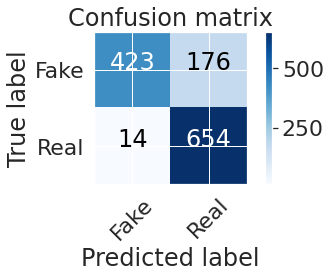

In [120]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

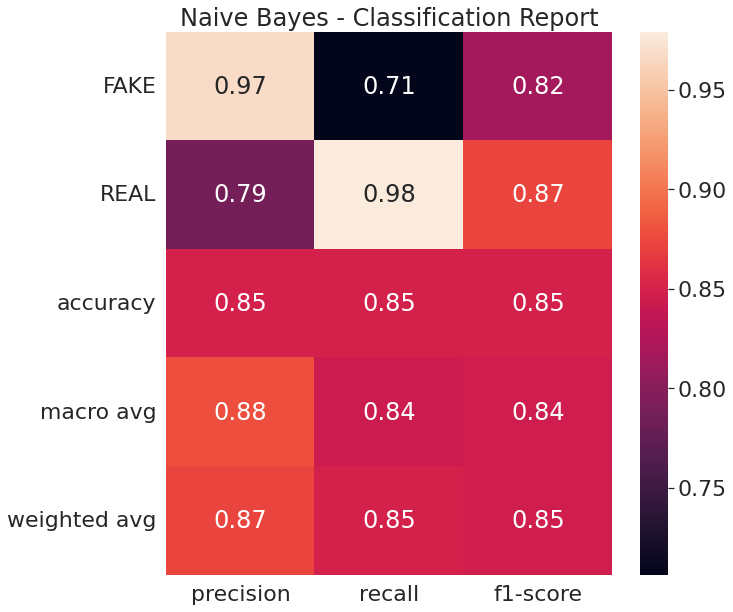

In [121]:
from sklearn.metrics import classification_report
# import seaborn as sns
sns.set_style('darkgrid')

# print(classification_report(y_test,
#                             prediction))

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
# target_names = list("PN")

clf_report = classification_report(y_test, prediction, output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("Naive Bayes - Classification Report");

In [122]:
# from sklearn import model_selection
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import KFold
# import numpy

# from sklearn.naive_bayes import MultinomialNB

# NB_classifier = MultinomialNB()
# # pipe = Pipeline([('vect', CountVectorizer()),
# #                  ('tfidf', TfidfTransformer()),
# #                  ('model', NB_classifier)])


# X, y = data['text'], data['target']
# metric = []

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text'], data['target'], random_state=1)
# kf = KFold(n_splits=5)
# kf.get_n_splits(X_train)
# for train_index, test_index in kf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , 
#     stop_words="english")
#     X_train_dtm = vect.fit_transform(X_train)
#     X_test_dtm = vect.transform(X_test)
#     model = NB_classifier.fit(X_train_dtm, y_train)
#     # nb.fit(X_train_dtm, y_train)
#     y_pred_class = model.predict(X_test_dtm)

#     metric.append(accuracy_score(y_test, y_pred_class))

# metric = numpy.array(metric)
# print('Mean accuracy: ', numpy.mean(metric, axis=0))
# print('Std for accuracy: ', numpy.std(metric, axis=0))

# **Logistic regression**

In [123]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 90.77%


Confusion matrix, without normalization


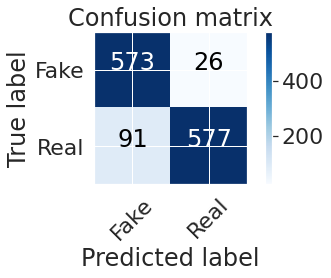

In [124]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

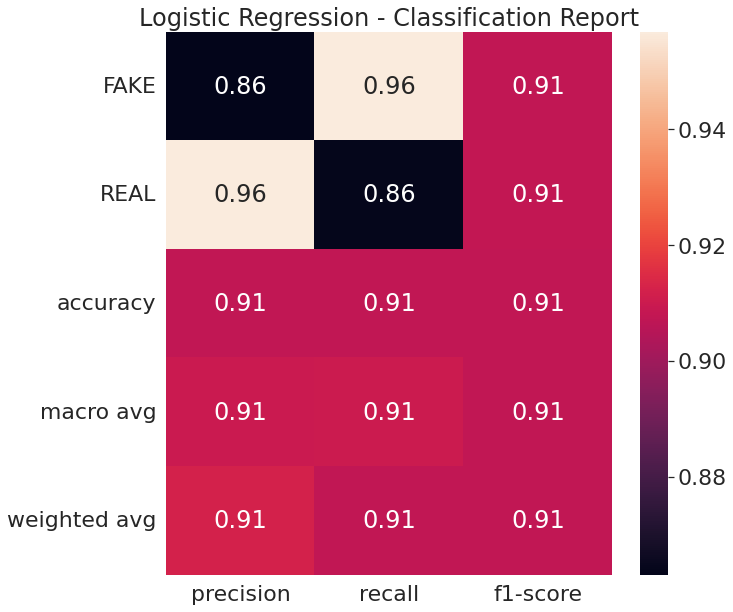

In [125]:
from sklearn.metrics import classification_report
# import seaborn as sns
sns.set_style('darkgrid')

# print(classification_report(y_test,
#                             prediction))

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
# target_names = list("PN")

clf_report = classification_report(y_test, prediction, output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("Logistic Regression - Classification Report");

In [126]:
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import KFold
# import numpy

# from sklearn.linear_model import LogisticRegression

# # pipe = Pipeline([('vect', CountVectorizer()),
# #                  ('tfidf', TfidfTransformer()),
# #                  ('model', LogisticRegression())])

# metric = []

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text'], data['target'], random_state=1)
# kf = KFold(n_splits=5)
# kf.get_n_splits(X_train)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , 
#     stop_words="english")
#     X_train_dtm = vect.fit_transform(X_train)
#     X_test_dtm = vect.transform(X_test)
#     # nb = LogisticRegression()
#     # nb.fit(X_train_dtm, y_train)
#     model = LogisticRegression(max_iter=400).fit(X_train_dtm, y_train)
#     y_pred_class = model.predict(X_test_dtm)

#     metric.append(accuracy_score(y_test, y_pred_class))

# metric = numpy.array(metric)
# print('Mean accuracy: ', numpy.mean(metric, axis=0))
# print('Std for accuracy: ', numpy.std(metric, axis=0))

# **Decision Tree**

In [127]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 80.27%


Confusion matrix, without normalization


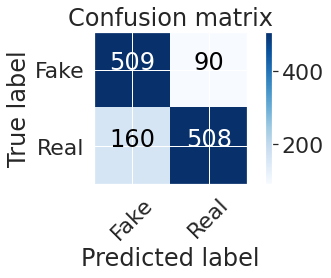

In [128]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

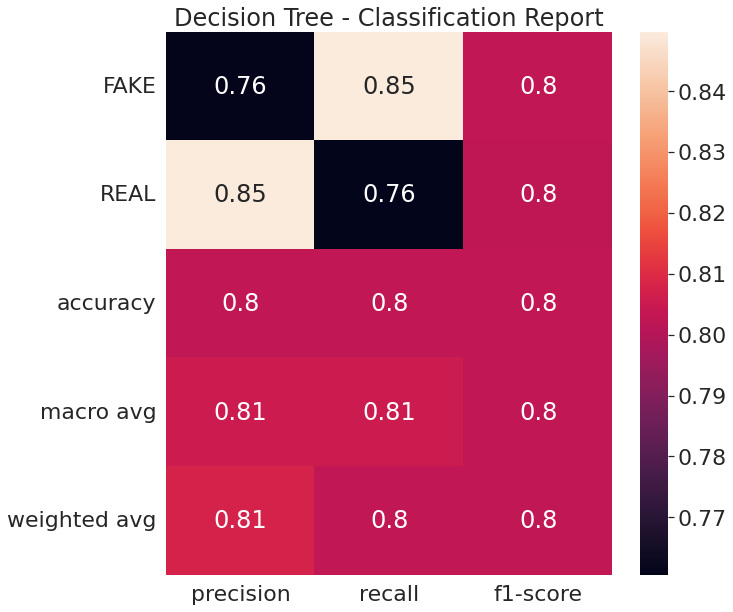

In [129]:
from sklearn.metrics import classification_report
# import seaborn as sns
sns.set_style('darkgrid')

# print(classification_report(y_test,
#                             prediction))

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
# target_names = list("PN")

clf_report = classification_report(y_test, prediction, output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("Decision Tree - Classification Report");

In [130]:
# from sklearn import model_selection
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import KFold
# import numpy

# from sklearn.tree import DecisionTreeClassifier

# # Vectorizing and applying TF-IDF
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', DecisionTreeClassifier(criterion= 'entropy',
#                                            max_depth = 20, 
#                                            splitter='best', 
#                                            random_state=42))])

# metric = []

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text'], data['target'], random_state=1)
# kf = KFold(n_splits=5)
# kf.get_n_splits(X_train)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , 
#     stop_words="english")
#     X_train_dtm = vect.fit_transform(X_train)
#     X_test_dtm = vect.transform(X_test)
#     # nb = DecisionTreeClassifier()
#     # nb.fit(X_train_dtm, y_train)
#     model = DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42).fit(X_train_dtm, y_train)
#     y_pred_class = model.predict(X_test_dtm)

#     metric.append(accuracy_score(y_test, y_pred_class))

# metric = numpy.array(metric)
# print('Mean accuracy: ', numpy.mean(metric, axis=0))
# print('Std for accuracy: ', numpy.std(metric, axis=0))

# **Random Forest**

In [131]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 89.42%


Confusion matrix, without normalization


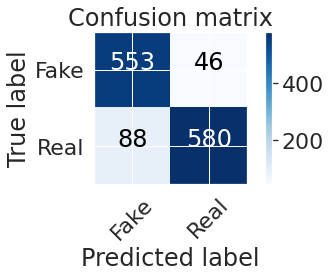

In [132]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

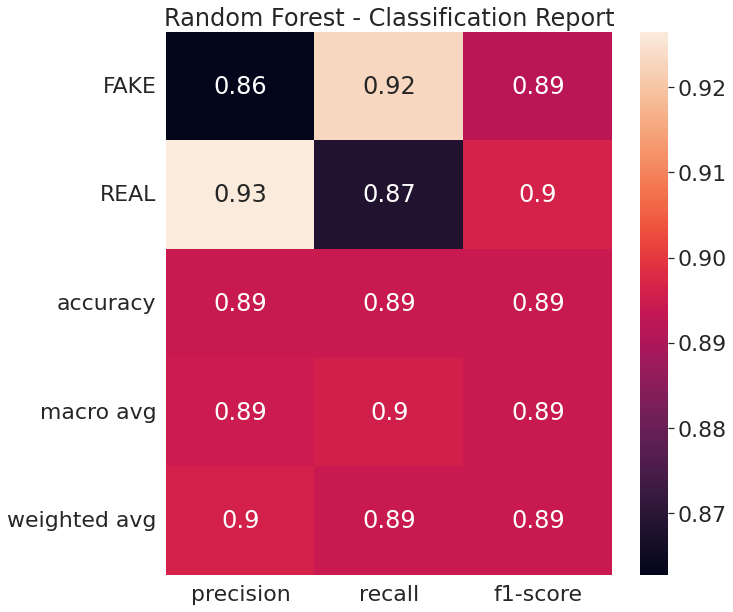

In [133]:
from sklearn.metrics import classification_report
# import seaborn as sns
sns.set_style('darkgrid')

# print(classification_report(y_test,
#                             prediction))

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
# target_names = list("PN")

clf_report = classification_report(y_test, prediction, output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("Random Forest - Classification Report");

In [134]:
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import KFold
# import numpy

# from sklearn.ensemble import RandomForestClassifier

# # pipe = Pipeline([('vect', CountVectorizer()),
# #                  ('tfidf', TfidfTransformer()),
# #                  ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

# metric = []

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text'], data['target'], random_state=1)
# kf = KFold(n_splits=5)
# kf.get_n_splits(X_train)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , 
#     stop_words="english")
#     X_train_dtm = vect.fit_transform(X_train)
#     X_test_dtm = vect.transform(X_test)
#     # nb = RandomForestClassifier()
#     # nb.fit(X_train_dtm, y_train)
#     model = RandomForestClassifier(n_estimators=50, criterion="entropy").fit(X_train_dtm, y_train)
#     y_pred_class = model.predict(X_test_dtm)

#     metric.append(accuracy_score(y_test, y_pred_class))

# metric = numpy.array(metric)
# print('Mean accuracy: ', numpy.mean(metric, axis=0))
# print('Std for accuracy: ', numpy.std(metric, axis=0))

## **SVM**

In [135]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 93.76%


Confusion matrix, without normalization


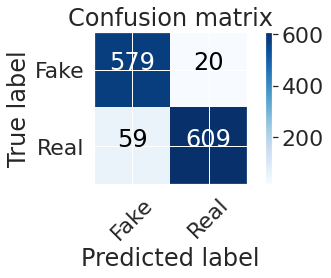

In [136]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

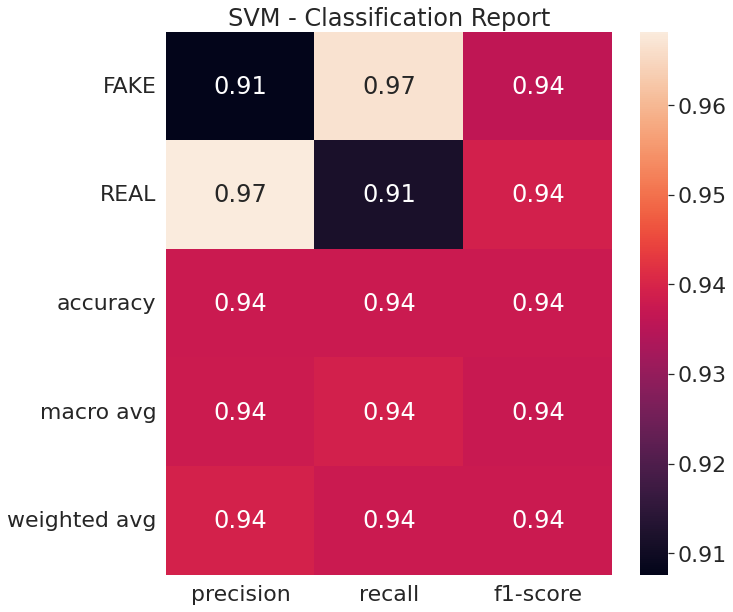

In [137]:
from sklearn.metrics import classification_report
# import seaborn as sns
sns.set_style('darkgrid')

# print(classification_report(y_test,
#                             prediction))

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
# target_names = list("PN")

clf_report = classification_report(y_test, prediction, output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("SVM - Classification Report");

In [138]:
# from sklearn import model_selection
# from sklearn import svm
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import KFold
# import numpy

# from sklearn import svm

# #Create a svm Classifier
# clf = svm.SVC(kernel='linear') # Linear Kernel

# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', clf)])

# metric = []

# clf = svm.SVC(kernel='linear')

# X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text'], data['target'], random_state=1)
# kf = KFold(n_splits=5)
# kf.get_n_splits(X_train)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , 
#     stop_words="english")
#     X_train_dtm = vect.fit_transform(X_train)
#     X_test_dtm = vect.transform(X_test)
#     # nb = clf
#     # nb.fit(X_train_dtm, y_train)
#     model = clf.fit(X_train_dtm, y_train)
#     y_pred_class = model.predict(X_test_dtm)

#     metric.append(accuracy_score(y_test, y_pred_class))

# metric = numpy.array(metric)
# print('Mean accuracy: ', numpy.mean(metric, axis=0))
# print('Std for accuracy: ', numpy.std(metric, axis=0))

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x7f953b5aca90>,
 <a list of 13 Text major ticklabel objects>)

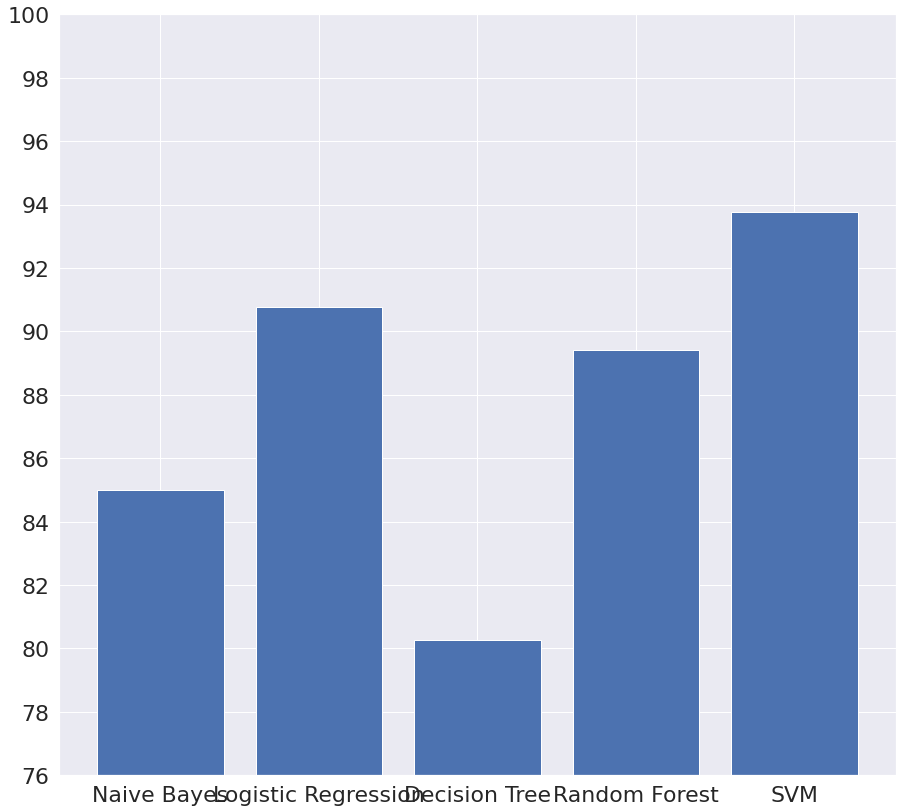

In [144]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,14))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((76,78,80,82,84,86,88,90,92,94,96,98,100))

In [140]:
the end.....

SyntaxError: ignored